## Importing library

In [1]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy import signal
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import keras
import sys

D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

## Loding data

In [2]:
from scipy.fftpack import fft
from scipy import signal
import pandas as pd
import numpy as np

SIGNALS = [
    "body_acc_x", "body_acc_y", "body_acc_z",
    "body_gyro_x", "body_gyro_y", "body_gyro_z",
    "total_acc_x", "total_acc_y", "total_acc_z"
]

#------------------------------------------------------------------------------
def _read_csv(subset, signal):
    if subset==' ': return pd.read_csv(f'./phonesData/{signal}.txt', delim_whitespace=True, header=None)
    else:           return pd.read_csv(f'./{subset}Data/{signal}_{subset}.txt', delim_whitespace=True, header=None)

def _median_filter(data):
    return signal.medfilt(data, [1,3])

def _low_pass_butterworth_filter(cutoff, freq, data):
    b, a = signal.butter(3, 2*cutoff/freq, btype='lowpass', analog=False, output='ba')
    return signal.filtfilt(b, a, data)

def _normalization(data):
    normalized = np.empty(shape=data.shape)
    mean = np.mean(data, axis=1)
    std = np.std(data, axis=1)
    for row in range(data.shape[0]):
        if not std[row] == 0:
            for col in range(data.shape[1]):
                normalized[row][col] = (data[row][col] - mean[row]) / std[row]
    return normalized

def _FFT(data):
    return abs(fft(data))/128

def _shuffle(data, index):
    return data[index]

#------------------------------------------------------------------------------
def Load_data(subset):
    data = []
    for signal in SIGNALS:
        data.append( _read_csv(subset, signal).to_numpy())
    return data

def Load_target(subset):
    return np.eye(6, dtype=int)[_read_csv(subset, 'y')[0]-1]
#     return pd.get_dummies(_read_csv(subset, 'y')[0]).to_numpy()

def Expand(expand, data):
    new_data = []
    for i in range(9) : new_data.append(data[i])
    if expand=='e':
        for i in range(3): new_data.append(data[i])
    return new_data

def Normalize(data):
    new_data = []
    for i in range(len(data)):
        new_data.append( _normalization(data[i]) )
    return new_data

def Time_to_Freq(data):
    new_data = []
    for i in range(len(data)):
        new_data.append( _FFT(data[i]) )
    return new_data

def Reshape(data):
    data = np.transpose(data, (1,2,0))
    return data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)

def Combine(time, freq):
    return np.transpose([time, freq], (2,3,1,0))

def Shuffle(index, data, channel, y):
    new_data = np.empty(shape=data.shape)
    for ch in range(channel):
        for i in range(len(index)):
            if y==True: new_data[i,:] = data[index[i],:]
            else: new_data[i,:,:,ch] = data[index[i],:,:,ch]
    return new_data

In [3]:
# sys.path.append("./data_preprocess.py")
# import data_preprocess
# X_train_list, X_test_list, y_train, y_test = data_preprocess.load_ALL_data()

raw_train, raw_test = Load_data('train'), Load_data('test')
raw_y_train, y_test = Load_target('train'), Load_target('test')

In [16]:
expand = 'e' # n/e, n: 9 signals; e: 12 signals
shuffle_index = np.arange(raw_y_train.shape[0])
np.random.shuffle(shuffle_index)

time_Nn_train, time_Nn_test = Expand(expand, raw_train), Expand(expand, raw_test)

In [6]:
# if 'FN' in dataset or 'BN' in dataset or 'A' in dataset or 'TN' in dataset:  # TN FN BN A
#     time_Ny_train, time_Ny_test = Normalize(time_Nn_train), Normalize(time_Nn_test)
#     print("TN/FN/BN/A")
    
# if 'F' in dataset or 'B' in dataset or 'A' in dataset: # F B A
#     freq_Nn_train, freq_Nn_test = Time_to_Freq(time_Nn_train), Time_to_Freq(time_Nn_test)
#     print("F/B/A")
    
# if 'FN' in dataset or 'BN' in dataset or 'A' in dataset: # FN BN A
#     freq_Ny_train, freq_Ny_test = Time_to_Freq(time_Ny_train), Time_to_Freq(time_Ny_test)
#     print("FN/BN/A")
time_Ny_train, time_Ny_test = Normalize(time_Nn_train), Normalize(time_Nn_test)
freq_Nn_train, freq_Nn_test = Time_to_Freq(time_Nn_train), Time_to_Freq(time_Nn_test)
freq_Ny_train, freq_Ny_test = Time_to_Freq(time_Ny_train), Time_to_Freq(time_Ny_test)

In [7]:
dataset = 'A'  # [(T/F/B/)/N]/A, T: time domian; F: freq. domian; B: both time and freq. domain; A: all; N; normalize
                # dataset: T / TN / F / FN / B / BN / A

if 'T' in dataset:
    X_train = Shuffle(shuffle_index, Reshape(time_Nn_train),1,False)
    X_test  = Reshape(time_Nn_test)
elif 'TN' in dataset:
    X_train = Shuffle(shuffle_index, Reshape(time_Ny_train),1,False)
    X_test  = Reshape(time_Ny_test)
elif 'F' in dataset:
    X_train = Shuffle(shuffle_index, Reshape(freq_Nn_train),1,False)
    X_test  = Reshape(freq_Nn_test)
elif 'FN' in dataset:
    X_train = Shuffle(shuffle_index, Reshape(freq_Ny_train),1,False)
    X_test  = Reshape(freq_Ny_test)
elif 'B' in dataset:
    X_train = Shuffle(shuffle_index, Combine(time_Nn_train, freq_Nn_train),2,False)
    X_test  = Combine(time_Nn_test, freq_Nn_test)
elif 'BN' in dataset:
    X_train = Shuffle(shuffle_index, Combine(time_Ny_train, freq_Ny_train),2,False)
    X_test  = Combine(time_Ny_test, freq_Ny_test)
elif 'A' in dataset:
    X_train = [Shuffle(shuffle_index, Reshape(time_Nn_train),1,False),
               Shuffle(shuffle_index, Reshape(time_Ny_train),1,False),
               Shuffle(shuffle_index, Reshape(freq_Nn_train),1,False),
               Shuffle(shuffle_index, Reshape(freq_Ny_train),1,False),
               Shuffle(shuffle_index, Combine(time_Nn_train, freq_Nn_train),2,False),
               Shuffle(shuffle_index, Combine(time_Ny_train, freq_Ny_train),2,False)]
    X_test  = [Reshape(time_Nn_test),
               Reshape(time_Ny_test),
               Reshape(freq_Nn_test),
               Reshape(freq_Ny_test),
               Combine(time_Nn_test, freq_Nn_test),
               Combine(time_Ny_test, freq_Ny_test)]
    
y_train = Shuffle(shuffle_index, raw_y_train,1,True)

In [20]:
print(X_train.shape) if 'A' not in dataset else print(len(X_train))
print(X_test.shape) if 'A' not in dataset else print(len(X_test))
print(y_train.shape)


6
6
(7352, 6)


In [21]:
raw_new = Load_data(' ')
raw_new_y = Load_target(' ')
print(raw_y_train[:7])
print(raw_new_y)


# new = Reshape(Expand(expand, Time_to_Freq(raw_new)))
new = Reshape(Expand(expand, raw_new))

print(new.shape)

[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]
[[0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]]
(7, 128, 12, 1)


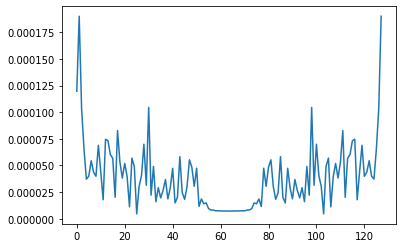

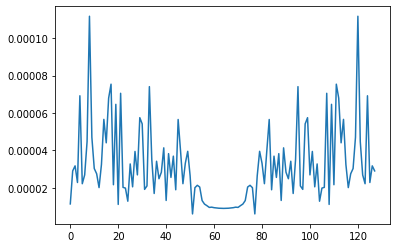

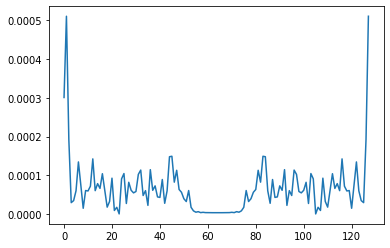

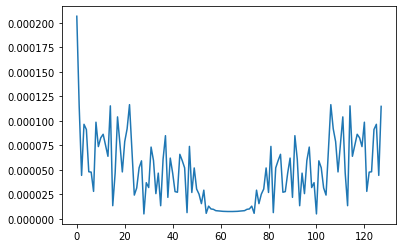

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(Time_to_Freq(raw_new)[0][0])
plt.show()
plt.clf()
plt.plot(Time_to_Freq(raw_new)[1][0])
plt.show()
plt.clf()
plt.plot(Time_to_Freq(raw_new)[2][0])
plt.show()
plt.clf()
plt.plot(Time_to_Freq(raw_new)[3][0])
plt.show()
plt.clf()

## Function

In [10]:
def show_train_history(H):
    for length in range(len(H)):
        plt.plot(H[length].history['val_loss'])
    plt.title('Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
#     plt.legend(['BS:64', 'BS:64', 'BS:128', 'BS:128', 'BS:256', 'BS:256'], loc='upper right')
    plt.show()
    plt.clf()
    
    for length in range(len(H)):
        plt.plot(H[length].history['val_accuracy'])
    plt.title('Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
#     plt.legend(['BS:64', 'BS:64', 'BS:128', 'BS:128', 'BS:256', 'BS:256'], loc='upper right')
    plt.show()
    plt.clf()

## CNN model

In [11]:
from keras.models import Sequential
from keras.layers import Activation,Dense,Dropout,Flatten,Conv2D,MaxPooling2D,Flatten,LSTM
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import regularizers

def CNN_model(channel):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(13,6), strides=(1,3),  input_shape=(128, 12, channel)))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

    model.add(Conv2D(filters=64, kernel_size=(13,3), strides=(1,1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

    model.add(Conv2D(filters=128, kernel_size=(12,1), strides=(1,1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(MaxPooling2D(pool_size=(2,1), strides=(2,1)))

    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(6, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
    model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
sys.path.append("../HAR_Test/confusion_matrix.py")
from confusion_matrix import confusion_matrix
sys.path.append("./model.py")
import model

def training(X_train, y_train, X_test, y_test, validation_split, BS, Epochs):
    model_CNN = CNN_model(X_train.shape[3])
    history = model_CNN.fit(X_train, y_train, validation_split=validation_split, shuffle=True, batch_size=BS, epochs=Epochs)
    print('\ntrain predict: \n', confusion_matrix(y_train, model_CNN.predict(X_train)))
    print('\ntest predict: \n', confusion_matrix(y_test, model_CNN.predict(X_test)))
    score = model_CNN.evaluate(X_test, y_test)
    print("\ntest accuracy: ", score[1])
    return history


In [23]:
history = []
history.append(training(X_train[0], y_train, new, raw_new_y, 0.15, 300, 15))

Train on 6249 samples, validate on 1103 samples
Epoch 1/15
6249/6249 [==============================] - 10s 2ms/step - loss: 1.1153 - accuracy: 0.6775 - val_loss: 6.5871 - val_accuracy: 0.5032
Epoch 2/15
6249/6249 [==============================] - 9s 1ms/step - loss: 0.4658 - accuracy: 0.8784 - val_loss: 0.3513 - val_accuracy: 0.9193
Epoch 3/15
6249/6249 [==============================] - 9s 1ms/step - loss: 0.2948 - accuracy: 0.9333 - val_loss: 0.3591 - val_accuracy: 0.8930
Epoch 4/15
6249/6249 [==============================] - 9s 1ms/step - loss: 0.2359 - accuracy: 0.9398 - val_loss: 0.3070 - val_accuracy: 0.8939
Epoch 5/15
6249/6249 [==============================] - 9s 1ms/step - loss: 0.2143 - accuracy: 0.9421 - val_loss: 0.1808 - val_accuracy: 0.9556
Epoch 6/15
6249/6249 [==============================] - 10s 2ms/step - loss: 0.1708 - accuracy: 0.9493 - val_loss: 0.1584 - val_accuracy: 0.9556
Epoch 7/15
6249/6249 [==============================] - 9s 2ms/step - loss: 0.1577 - a

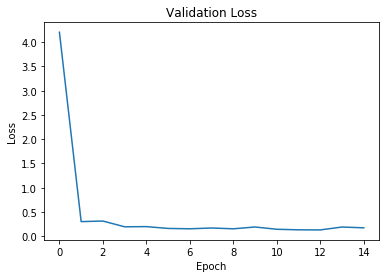

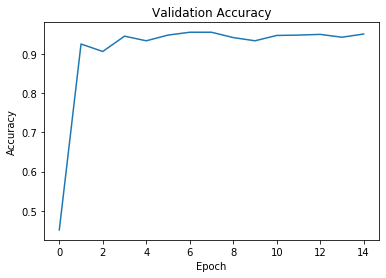

<Figure size 432x288 with 0 Axes>

In [18]:
show_train_history(history)

In [ ]:
history = []
history.append(training(X_train[1], y_train, X_test[1], y_test, 0.15, 300, 15))

In [ ]:
show_train_history(history)

In [ ]:
history = []
history.append(training(X_train[2], y_train, X_test[2], y_test, 0.15, 300, 15))

In [ ]:
show_train_history(history)

In [ ]:
history = []
history.append(training(X_train[3], y_train, X_test[3], y_test, 0.15, 300, 15))

In [ ]:
show_train_history(history)

In [ ]:
history = []
history.append(training(X_train[4], y_train, X_test[4], y_test, 0.15, 300, 15))

In [ ]:
show_train_history(history)

In [ ]:
history = []
history.append(training(X_train[5], y_train, X_test[5], y_test, 0.15, 300, 15))

In [ ]:
show_train_history(history)